## Approach (based on https://web.stanford.edu/~jurafsky/slp3/ - Jurafsky 2018)
1. POS tagging and entity chunking
2. For each verb in *s*, find the longest sequence of words *w* that start with a verb and satisfy syntactic and lexical constraints, merging adjacent matches
3. For each phrase *w*, find the nearest noun phrase *x* to the left which is not a relative pronoun, wh-word or existential "there". Find the nearest noun phrase *y* to the right.
4. Assign confidence *c* to the relation *r=(x,w,y)* using confidence classifier and return it.

A relation is only accepted if it meets syntactic and lexical contraints.

In [1]:
import spacy
import os
import re
import nltk

from nltk.tokenize import sent_tokenize, word_tokenize

# for plotting the dependency tree
path_to_gs = "C:/Program Files/gs/gs9.25/bin"
os.environ['PATH'] += os.pathsep + path_to_gs

# loading german spacy model
#nlp = spacy.load('de_core_news_sm')
nlp = spacy.load('en')

### Grammar for Lexical contraints

In [36]:
# for spaCy POS Tags
# V | VP | VW*P
grammar = r"""NP: {<DT>?<JJ>*<PROPN>}
              V: {<VERB>}
              W: {<NOUN|ADJ|ADV|PROPN|DET>}
              P: {<ADP|PART|PUNCT>}
              REL: {<V><W>*<P>|<V><P>|<V>}
              """

In [114]:
utterance = 'United has a hub in Chicago, which is the headquarter of United Continental Holdings. \
             Tim Cook is the CEO of Apple.\
             Bill Gates is the founder of Microsoft.'

In [38]:
utterance_long = u'''Meine kleine Enkelin Lisa und mein Enkel Lukas fliegen morgen nach London. Sie sind zum ersten Mal in England. 
Peter und Maria gehen morgen ins Kino. Ich und mein Sohn gehen heute zum Fußball. 
Ich gehe mit Johann in den Zoo.'''

In [116]:
sentences = sent_tokenize(utterance)
sentences

['United has a hub in Chicago, which is the headquarter of United Continental Holdings.',
 'Tim Cook is the CEO of Apple.',
 'Bill Gates is the founder of Microsoft.']

In [118]:
pos_tagged_sentences = []

for sentence in sentences:
    doc = nlp(sentence)
    
    pos_tagged_sentence = []
    for token in doc:
        pos_tuple = (token.text, token.pos_)
        pos_tagged_sentence.append(pos_tuple)
        
    pos_tagged_sentences.append(pos_tagged_sentence)
    
pos_tagged_sentences

[[('United', 'PROPN'),
  ('has', 'VERB'),
  ('a', 'DET'),
  ('hub', 'NOUN'),
  ('in', 'ADP'),
  ('Chicago', 'PROPN'),
  (',', 'PUNCT'),
  ('which', 'ADJ'),
  ('is', 'VERB'),
  ('the', 'DET'),
  ('headquarter', 'NOUN'),
  ('of', 'ADP'),
  ('United', 'PROPN'),
  ('Continental', 'PROPN'),
  ('Holdings', 'PROPN'),
  ('.', 'PUNCT')],
 [('Tim', 'PROPN'),
  ('Cook', 'PROPN'),
  ('is', 'VERB'),
  ('the', 'DET'),
  ('CEO', 'PROPN'),
  ('of', 'ADP'),
  ('Apple', 'PROPN'),
  ('.', 'PUNCT')],
 [('Bill', 'PROPN'),
  ('Gates', 'PROPN'),
  ('is', 'VERB'),
  ('the', 'DET'),
  ('founder', 'NOUN'),
  ('of', 'ADP'),
  ('Microsoft', 'PROPN'),
  ('.', 'PUNCT')]]

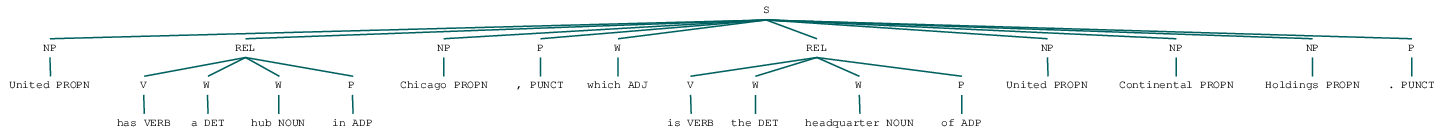

In [125]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[0])

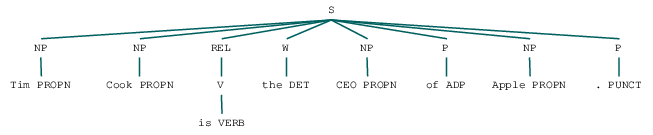

In [126]:
cp = nltk.RegexpParser(grammar)
cp.parse(pos_tagged_sentences[1])

In [127]:
cp = nltk.RegexpParser(grammar)
sentence_trees = []

for sentence in pos_tagged_sentences:
    sentence_trees.append(cp.parse(sentence))

sentence_trees

[Tree('S', [Tree('NP', [('United', 'PROPN')]), Tree('REL', [Tree('V', [('has', 'VERB')]), Tree('W', [('a', 'DET')]), Tree('W', [('hub', 'NOUN')]), Tree('P', [('in', 'ADP')])]), Tree('NP', [('Chicago', 'PROPN')]), Tree('P', [(',', 'PUNCT')]), Tree('W', [('which', 'ADJ')]), Tree('REL', [Tree('V', [('is', 'VERB')]), Tree('W', [('the', 'DET')]), Tree('W', [('headquarter', 'NOUN')]), Tree('P', [('of', 'ADP')])]), Tree('NP', [('United', 'PROPN')]), Tree('NP', [('Continental', 'PROPN')]), Tree('NP', [('Holdings', 'PROPN')]), Tree('P', [('.', 'PUNCT')])]),
 Tree('S', [Tree('NP', [('Tim', 'PROPN')]), Tree('NP', [('Cook', 'PROPN')]), Tree('REL', [Tree('V', [('is', 'VERB')])]), Tree('W', [('the', 'DET')]), Tree('NP', [('CEO', 'PROPN')]), Tree('P', [('of', 'ADP')]), Tree('NP', [('Apple', 'PROPN')]), Tree('P', [('.', 'PUNCT')])]),
 Tree('S', [Tree('NP', [('Bill', 'PROPN')]), Tree('NP', [('Gates', 'PROPN')]), Tree('REL', [Tree('V', [('is', 'VERB')]), Tree('W', [('the', 'DET')]), Tree('W', [('founder

### find the nearest noun phrase to REL

In [128]:
relations = []

for tree in sentence_trees:
    for i, node in enumerate(tree):
        if node.label() == 'REL':
            rel = node
            
            # find the nearest NP to the left of REL
            for j in range(i-1, -1, -1):
                if tree[j].label() == 'NP':
                    #print(f'left NP {j}: {tree[j]}')
                    left_noun = tree[j]
                    break
            # find the nearest NP to the right of REL
            for j in range(i+1, len(tree), 1):
                if tree[j].label() == 'NP':
                    #print(f'right NP {j}: {tree[j]}')
                    right_noun = tree[j]
                    break
    
            relations.append([left_noun, rel, right_noun])   

relations

[[Tree('NP', [('United', 'PROPN')]),
  Tree('REL', [Tree('V', [('has', 'VERB')]), Tree('W', [('a', 'DET')]), Tree('W', [('hub', 'NOUN')]), Tree('P', [('in', 'ADP')])]),
  Tree('NP', [('Chicago', 'PROPN')])],
 [Tree('NP', [('Chicago', 'PROPN')]),
  Tree('REL', [Tree('V', [('is', 'VERB')]), Tree('W', [('the', 'DET')]), Tree('W', [('headquarter', 'NOUN')]), Tree('P', [('of', 'ADP')])]),
  Tree('NP', [('United', 'PROPN')])],
 [Tree('NP', [('Cook', 'PROPN')]),
  Tree('REL', [Tree('V', [('is', 'VERB')])]),
  Tree('NP', [('CEO', 'PROPN')])],
 [Tree('NP', [('Gates', 'PROPN')]),
  Tree('REL', [Tree('V', [('is', 'VERB')]), Tree('W', [('the', 'DET')]), Tree('W', [('founder', 'NOUN')]), Tree('P', [('of', 'ADP')])]),
  Tree('NP', [('Microsoft', 'PROPN')])]]

In [129]:
relation_tuples = []
for relation in relations:
    relation_tuple = []
    for tree in relation:
        words = [w for w, t in tree.leaves()]
        relation_tuple.append(words)

    relation_tuples.append(relation_tuple)

relation_tuples

[[['United'], ['has', 'a', 'hub', 'in'], ['Chicago']],
 [['Chicago'], ['is', 'the', 'headquarter', 'of'], ['United']],
 [['Cook'], ['is'], ['CEO']],
 [['Gates'], ['is', 'the', 'founder', 'of'], ['Microsoft']]]

## Draw relationships as network with networkx

In [130]:
import os
import networkx as nx
import matplotlib.pyplot as plt

from networkx import nx_pydot

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

In [131]:
ng = nx.Graph()

for relation in relation_tuples:
    source = relation[0][0]
    target = relation[2][0]
    print(f"Source: {source}, Target: {target}, Weight: {1}")
    ng.add_edge(source, target, weight=1)


Source: United, Target: Chicago, Weight: 1
Source: Chicago, Target: United, Weight: 1
Source: Cook, Target: CEO, Weight: 1
Source: Gates, Target: Microsoft, Weight: 1


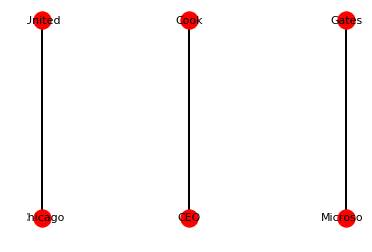

In [135]:
e_small = [(u, v) for (u, v, d) in ng.edges(data=True) if d['weight'] <= 3]
e_middle = [(u, v) for (u, v, d) in ng.edges(data=True) if d['weight'] <= 6]
e_large = [(u, v) for (u, v, d) in ng.edges(data=True) if d['weight'] > 6]
#pos = nx.spring_layout(ng)  # positions for all nodes
pos = nx.nx_pydot.graphviz_layout(ng, prog='dot')

# nodes
nx.draw_networkx_nodes(ng, pos, node_size=300)

# edges
nx.draw_networkx_edges(ng, pos, edgelist=e_small, width=1)
nx.draw_networkx_edges(ng, pos, edgelist=e_middle, width=2)
nx.draw_networkx_edges(ng, pos, edgelist=e_large, width=6)

# labels
nx.draw_networkx_labels(ng, pos, font_size=11, font_family='sans-serif')

plt.axis('off')  # disable axis
plt.show()

## TODO: tune NP chunking